# LAB -- Projectile Motion

**Please write your name in this box**

*We encourage you to work together, and seek whatever help you need in completing this lab.  Please list all people who you worked with or received help from*

*We encourage you to use any online resources that you find useful. Please list any URL's that you consulted*

*We encourage you to use AI resources if you find them useful.  If you made use of AI, please list the platform and the prompts which you made use of*

## Load in Packages

In [1]:
using Plots,ProgressMeter

<h2 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:blue; color:white;" >
## Goal
</h2>

Your goal in this lab is to write a function which will calculate the trajectory of a projectile, including drag forces. You will input the initial velocity (as a vector), and it will return a function which gives $x$ and $y$ as a function of time, until the object hits the ground.  You will then explore the distance that the projectile travels as a function of the launch angle.

In lecture we wrote a simple fixed time-step Runge Kutta integrator, and also the `DifferentialEquations.jl` package, which implements more sophisticated algorithms.  For this projectile problem, we need to stop the integrator when the projectile hits the ground.  A-priori we do not know when this occurs.  There are [mechanisms](https://docs.sciml.ai/DiffEqDocs/stable/features/callback_functions/)  to do this with `DifferentialEquations.jl`, but it will be much easier to simply use our hand-built integrator.  The effort needed to learn how to use the package is more than the effort to just code it ourself.

## Physics

A projectile obeys the second order differential equations:
\begin{align}
m\frac{d^2 {\bf \vec{r}}}{dt^2}&=
-m g {\bf\hat{y}}+{\bf\vec{F}}_d
\end{align}
where ${\bf\vec{F}}_d$ is the drag force.
In our approach to solving differential equations numerically, we need to write this as a set of coupled first order differential equations
\begin{align}
\frac{d {\bf \vec{r}}}{dt}&= {\bf \vec{v}}\\
\frac{d {\bf \vec{v}}}{dt}&=
-g {\bf\hat{y}}+\frac{{\bf\vec{F}}_d}{m}
\end{align}
We create a length 4 vector whose components are $(x,y,vx,vy)$, and update this vector at each time step.

In a typical introductory physics course one introduces two different models for ${\bf\vec{F}}_d$:
\begin{align}
{\bf\vec{F}}_d^{(1)}&=-\alpha {\bf\vec{v}}\\
{\bf\vec{F}}_d^{(2)}&=-\beta |v|{\bf\vec{v}}.
\end{align}
Linear drag is typically a good model for laminar flow in highly viscous media.  Quadratic drag is typically a good model for turbulent flow.  Typical projectiles are better modelled by quadratic drag.  An ansatz which interpolates between these is
$$
{\bf\vec{F}}_d=-\gamma |v|^{\delta-1}{\bf\vec{v}}.
$$
The case $\delta=1$ corresponds to linear drag, and $\delta=2$ to quadratic drag.

As usual, we need to *adimensionalize* these equations.  There two natural options for doing this for the current problem:
1. We could use an arbitrary fixed set of units.  For example, we know that most projectile problems that we deal with will involve meters, seconds, meters/seconds.  So we could simply use numerical values in SI units
2. We could extract the scale from the inital conditions.  For example, if the initial speed is $v_0$, then a good characteristic time is $\tau=v_0/g$, and a good characteristic distance is $v_0^2/g$.

Here we will use the first approach.  We will call our function with $v0x,v0y,g,\gamma,\delta$, and assume the user has chosen the numerical values so that they are all dimensionally consistent.   

Caution:  If you use an arbitrary fixed set of units, be careful that your parameters do not end up either extremely large or extremely small.  Don't use meters for an atomic problem, or seconds for a cosmology problem.  Otherwise you are vulnerable to round-off error, and a host of other challenges.

<h2 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:red; color:white;" >
## Question 1
</h2>

Assuming that one inputs $v_0$ in units of m/s, and $g$ in units of m/s$^2$.  What are the units for $\gamma$?

<h2 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:red; color:white;" >
## Activity 1
</h2>

For this activity we will try a workflow where we simultaneously have a notebook open and a text file open.  We will develop code in the notebook -- and then when it works copy it into the file.

If you are not already using JupyterLab, click the `Open in...` button, which appears on the upper right of the notebook.  Select `JupyterLab`.

Make sure that you are not in `Simple` mode.  There is a slider on the bottom left of the JupyterLab interface.  Make sure it is slid to the left.

Click on `File`, `New`, `Julia File`

Drag the title of the new file to the right.  You should be able to make it so that the notebook and the file are shown side-by-side

Right-click on the title and select "rename".  Call it  "Pendulumlab.jl"

Here is the code we developed in lecture for integrating a differential equation.  Copy the code to your ".jl" file, and save it

In [10]:
"""
    evolve(x0,dxdt,timerange,stepper)

integrates a differential equation.

`x0` - the dynamical variables at the original time -- can be a number, a vector, a tuple, etc
`dxdt(x,t)` -- a function of `x` and `t`,  Should return an object of the same type as `x0`
            -- evaluates to the right hand side of the differential equation
`timerange` -- a tuple `(ti,tf,dt)` listing the initial and final time, as well as the timestep
`stepper`

    stepper(x,dxdt,t,deltat))

gives you the value of `x` at the next timestep
"""
function evolve(x0,dxdt,timerange,stepper=rk4step)
    ti,tf,dt=timerange
    numsteps=floor(Int,(tf-ti)/dt)
    x=collect(x0) #converts to a vector
                  #works fine without "collect" if you restrict input to vectors
    result=Array{typeof(x)}(undef,numsteps+1)
    result[1]=x
    t=ti
    for j in 1:numsteps
        x=stepper(x=x,dxdt=dxdt,t=t,deltat=dt)
        result[j+1]=x
        t+=dt
    end
    return result
end

evolve(;x0,dxdt,timerange,stepper=eulerstep)=evolve(x0,dxdt,timerange,stepper)

function rk4step(x,dxdt,t,deltat)
    k1=dxdt(x,t)
    k2=dxdt(x+k1*(deltat/2),t+deltat/2)
    k3=dxdt(x+k2*(deltat/2),t+deltat/2)
    k4=dxdt(x+k3*deltat,t+deltat)
    return x+(k1+2*k2+2*k3+k4)*(deltat/6)
end

rk4step(;x,dxdt,t,deltat)=rk2step(x,dxdt,t,deltat)

function pendulum_dxdt(x,t)
    (theta,v)=x
    return [v,-sin(theta)]
end

pendulum_dxdt (generic function with 1 method)

You can load that file in with

In [2]:
include("Pendulumlab.jl")

distance (generic function with 2 methods)

Repeat that line whenever you change the file and want to update the state of your interactive session.  My recommendation is that you just put functions and object definitions in your file, and do the actual execution in your notebook

Test the routines in that file, by running the following lines

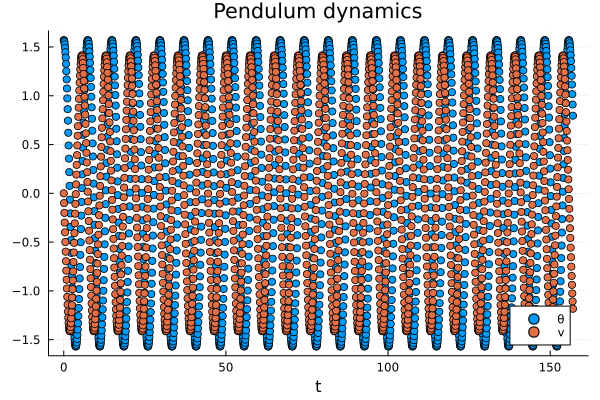

In [3]:
rk4ev=evolve([pi/2,0.],pendulum_dxdt,(0,50*pi,0.1),rk4step)
rk4times=0:0.1:50*pi
Plots.scatter(rk4times,first.(rk4ev),label="θ",xlabel="t",title="Pendulum dynamics")
Plots.scatter!(rk4times,last.(rk4ev),label="v",xlabel="t")

Finally, you will find it useful to open a "contextual help window".  Under the "Help" tab, select "Show Contextual Help".  Move the window so that it is on the same tab bar as `Pendulumlab.jl`.  You can then move between them as desired.

<h2 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:red; color:white;" >
## Activity 2
</h2>

Lets now try to integrate the differential equation for the projectile.  Lets start with the easy case, where we have no drag.  The equations are then
\begin{align}
\frac{d {\bf \vec{r}}}{dt}&= {\bf \vec{v}}\\
\frac{d {\bf \vec{v}}}{dt}&=
-g {\bf\hat{y}}
\end{align}
We can understand this as 4 equations
\begin{align}
\frac{dx}{dt}&=v_x\\
\frac{dy}{dt}&=v_y\\
\frac{dv_x}{dt}&=0\\
\frac{dv_y}{dt}&=-g\\
\end{align}
We will store the phase space position as a length 4 vector $xv=(x,y,v_x,v_y)$.

Caution:  In our `evolve` function we called the vector of dynamical variables `x` and the left hand side of our differential equation `dxdt`. That is kind of confusing.  Thus depending on where we are, we may be thinking of `x` as a length 4 vector, or `x` might be the x-component of position.  Whenever possible I will try to use `xv` for the length 4 vector -- but since we are working with already written code that uses the other notation, we will *code-switch* when necessary.

A further notational confusion is that we will have a `xv` as the length 4 vector, and the `vx` as the x-component of the velocity.  Hopefully that will not be an issue.

For our differential equation solver we need a function `dxvdt(xv,t)` which returns a length 4 vector $(dx/dt,dy/dt,dvx/dt,dvy/dt)$.  This function, of course, depends on what we choose $g$ to be.  Suppose we use SI units, and are working on Earth.  We might write 

In [17]:
function dxvdt_Earth(xv,t)
    x,y,vx,vy=xv
    return [vx,vy,0.,-9.8]
end

dxvdt_Earth (generic function with 1 method)

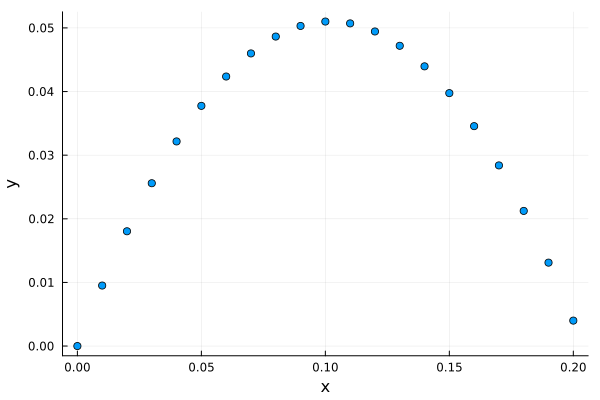

In [32]:
tmin=0.
tmax=0.2
dt=0.01
trajectory=evolve([0.,0.,1.,1.],dxvdt_Earth,(tmin,tmax,dt),rk4step)
times=tmin:dt:tmax
xvals=[xv[1] for xv in trajectory]
yvals=[xv[2] for xv in trajectory]
scatter(xvals,yvals,label="",xlabel="x",ylabel="y")

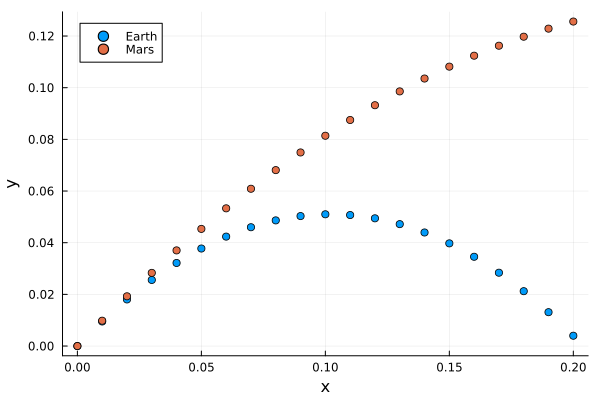

In [33]:
function dxvdt_Mars(xv,t)
    x,y,vx,vy=xv
    return [vx,vy,0.,-3.72]
end

trajectory_Mars=evolve([0.,0.,1.,1.],dxvdt_Mars,(tmin,tmax,dt),rk4step)
times=tmin:dt:tmax
xvals_Mars=[xv[1] for xv in trajectory_Mars]
yvals_Mars=[xv[2] for xv in trajectory_Mars]
scatter(xvals,yvals,label="Earth",xlabel="x",ylabel="y")
scatter!(xvals_Mars,yvals_Mars,label="Mars",xlabel="x",ylabel="y")

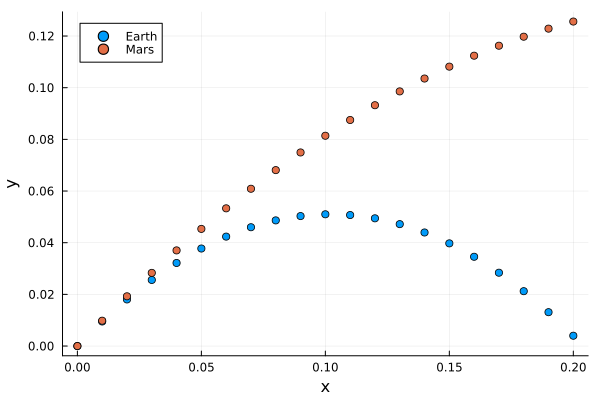

In [33]:
function dxvdt_Mars(xv,t)
    x,y,vx,vy=xv
    return [vx,vy,0.,-3.72]
end

trajectory_Mars=evolve([0.,0.,1.,1.],dxvdt_Mars,(tmin,tmax,dt),rk4step)
times=tmin:dt:tmax
xvals_Mars=[xv[1] for xv in trajectory_Mars]
yvals_Mars=[xv[2] for xv in trajectory_Mars]
scatter(xvals,yvals,label="Earth",xlabel="x",ylabel="y")
scatter!(xvals_Mars,yvals_Mars,label="Mars",xlabel="x",ylabel="y")

It would be really nice to be able to jump between planets, without writing a custom `dxvdt` every time.  We can do that with a **generator**, also known as a **factory**.  A generator is a function which returns a function.  For example

In [34]:
function make_dxvdt(g)
    function dxvdt(xv,t)
        x,y,vx,vy=xv
        return [vx,vy,0.,-g]
    end
    return dxvdt
end

make_dxvdt (generic function with 1 method)

In [36]:
dxvdt_test=make_dxvdt(9.8)

(::var"#dxvdt#47"{Float64}) (generic function with 1 method)

We can try that out with

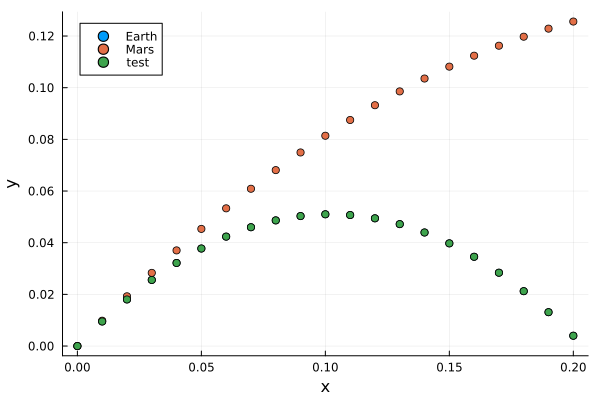

In [38]:
trajectory_test=evolve([0.,0.,1.,1.],dxvdt_test,(tmin,tmax,dt),rk4step)
times=tmin:dt:tmax
xvals_test=[xv[1] for xv in trajectory_test]
yvals_test=[xv[2] for xv in trajectory_test]
scatter(xvals,yvals,label="Earth",xlabel="x",ylabel="y")
scatter!(xvals_Mars,yvals_Mars,label="Mars",xlabel="x",ylabel="y")
scatter!(xvals_test,yvals_test,label="test",xlabel="x",ylabel="y")

As expected, the test values lie right on top of the Earth values.  Lets also try it with Mars

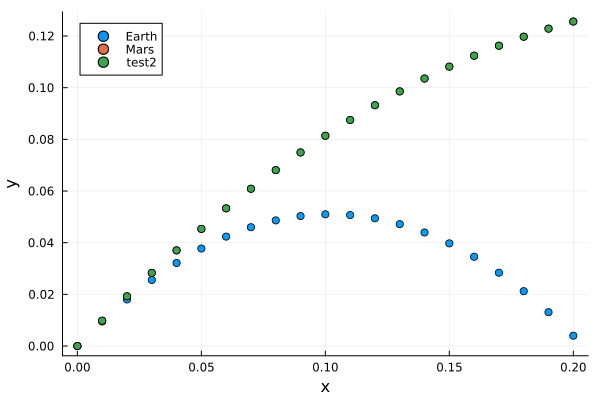

In [39]:
trajectory_test2=evolve([0.,0.,1.,1.],make_dxvdt(3.72),(tmin,tmax,dt),rk4step)
times=tmin:dt:tmax
xvals_test2=[xv[1] for xv in trajectory_test2]
yvals_test2=[xv[2] for xv in trajectory_test2]
scatter(xvals,yvals,label="Earth",xlabel="x",ylabel="y")
scatter!(xvals_Mars,yvals_Mars,label="Mars",xlabel="x",ylabel="y")
scatter!(xvals_test2,yvals_test2,label="test2",xlabel="x",ylabel="y")

Now they lie on top of the Mars Values.

We want to do the same thing, but include drag.  Our 4 equations are
\begin{align}
\frac{dx}{dt} &= v_x\\
\frac{dy}{dt} &= v_y\\
\frac{dv_x}{dt} &= -\gamma |v|^{\delta-1} v_x\\
\frac{dv_y}{dt} &= -g-\gamma |v|^{\delta-1} v_y.
\end{align}

Thus we would like a generator `make_dvxdt(g,γ,δ)` which returns a function `dvxdt(xv,t)`.  Again `xv=(x,y,vx,vy)`  and `dvxdt(xv,t)` returns a length 4 object `(dxdt,ydt,vxdt,vydt)`.

Write this generator, modeling it off of the the `make_dvxdt` that I provided in the absence of drag.

**Include a docstring which describes how your object is used.**  I like to write my docstrings first -- that way I have a clear goal. 

**Test your object by using different values of the parameters**

For example, if you set $\gamma=0$ it is easy to see if you are getting the gravity part right.  Then set $g=0$, and see if you are getting the drag part right.  Use a bunch of different velocity directions:  start with the cardinal directions, then do the case of 45 degrees.

Here are my test routines.  Work out on paper what you expect the answer to be, and compare to what you get.

    tstdvxdt0=make_dvxdt(1.,0.,1.)
    @show tstdvxdt0(0.,0.,0.,0.)

    tstdvxdt0b=make_dvxdt(2.,0.,1.)
    @show tstdvxdt0b(0.,0.,0.,0.)

    tstdvxdt1=make_dvxdt(0.,1.,1.)
    @show tstdvxdt1(0.,0.,1.,0.)
    @show tstdvxdt1(0.,0.,0.,1.)
    @show tstdvxdt1(0.,0.,2.,0.)
    @show tstdvxdt1(0.,0.,0.,2.)
    @show tstdvxdt1(0.,0.,1.,1.)

    tstdvxdt2=make_dvxdt(0.,2.,1.)
    @show tstdvxdt2(0.,0.,1.,0.)
    @show tstdvxdt2(0.,0.,0.,1.)
    @show tstdvxdt2(0.,0.,2.,0.)
    @show tstdvxdt2(0.,0.,0.,2.)
    @show tstdvxdt2(0.,0.,1.,1.)

    tstdvxdt3=make_dvxdt(0.,1.,2.)
    @show tstdvxdt2(0.,0.,1.,0.)
    @show tstdvxdt2(0.,0.,0.,1.)
    @show tstdvxdt2(0.,0.,2.,0.)
    @show tstdvxdt2(0.,0.,0.,2.)
    @show tstdvxdt2(0.,0.,1.,1.)

When your function is working, we should think of a name.  While `make_dxvdt` is great -- it is generic.  It doesn't tell us about what the physical system is.  I like `projectile_dxdt` or `projectile_dxvdt` -- depending on what makes most sense to you.  Copy your code, to define your function with that name (or another name that you like).  **Add a docstring** and whatever comments you think you might find useful in the future.  Also make it so that it can be called with either ordered arguments, or named arguments.  You can even give it default values if you want.

When you are happy, copy the code into the `Pendulumlab.jl` file.  Don't erase it from the notebook, and don't erase your testing.  The idea is that the notebook is a "Lab Notebook" documenting how you validated your functions.  At some later time you can look up what you did.  The `Pendulumlab.jl` is your "final program" which you can use in future work.

If you edit `Pendulumlab.jl` -- you can load in the edits to your interactive notebook session with `include("Pendulumlab.jl")`

<h2 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:red; color:white;" >
## Activity 3
</h2>

We are now ready to write a new version of our `evolve` function, which instead of running our stepper a fixed number of times, runs it until the projectile arrives at a position with $y<0$.

Go scroll though your `pendulum.jl` file so that you can see the code we used for `evolve`.  We will call our new function `projectile_trajectory` -- as it will return the trajectory of our projectile

The function will need to be called with:
-    `xv0` -- the initial (x,y,vx,vy)
-    `dxdt` -- the function which gives the derivatives
-    `dt` -- the timestep

We don't need to tell it which stepper to use -- we can just hard code it for `rk4`.    Also feel free to change the names of these to be sensible to you.  So the derivative function could be `dxvdt`.

Note: We do not know how many timesteps we will be taking.  Thus the command `result=Array{typeof(x)}(undef,numsteps+1)` doesn't make any sense.  Instead we will need to create an array of a single element, say with `result=[xv0]`, and later grow the trajectory list with `push!(result,xv)`.  Here is an example:

In [42]:
v1=[1.,2.]

2-element Vector{Float64}:
 1.0
 2.0

In [43]:
push!(v1,3.)
v1

3-element Vector{Float64}:
 1.0
 2.0
 3.0

Another thing we will need to deal with is the way we do the looping.  Look up the documentation for `while`.

Finally we need to worry about how we will return the answer.  The simplest is just returning a `tuple`  of the form `(times,xv_list)` -- where `times` is a vector of all the times, and `xv_list` is a vector of length-4 vectors (functionally a $N\times4$ matrix), which gives `xv` at each time.

**Write the `projectile_trajectory` function**.  Debugging/validating it is non-trivial.  Start by getting a working version, then go through the validating steps described below.  Use the logger or add  print statements to help figure out what is happening.

Don't forget to write a docstring

### Validation

Here are some test cases to look at.  Verify that your function acts correctly in each case.  Make plots or look at particular elements to convince yourself it is working.  For plots, do not forget to label your axes.

### Dropping off a cliff

Start with initial conditions: $(x,y,vx,vy)=(0.,1.,0.,0.)$, with parameters $m=1.,g=1.,\gamma=0.,\delta=1.$.  This corresponds to the elementary problem of dropping a rock off a cliff, neglecting drag.  

Verify that the $v_y(t)$ and $y(t)$ functions match what you expect.  

Double $g$, and make sure it changes as expected.  

### Frictionless Projectile

Now do the case $(x,y,vx,vy)=(0.,0.,1.,1.)$, with parameters $m=1.,g=1.,\gamma=0.,\delta=1.$.  Plot $y(t)$ vs $x(t)$.  If that works, double the initial $v_x$, and see if it makes the right change.  Now double the initial $v_y$. 

### Dropping a ball bearing in glycerol

Start with initial conditions: $(x,y,vx,vy)=(0,10,0,0)$, with parameters $m=1.g=1.,\gamma=1.,\delta=1.$.  This corresponds to the elementary problem of an object falling with viscous drag:
$$
\frac{d v_y}{dt}=-g-\frac{\gamma}{m} v_y
$$
One can integrate this to get
$$
v_y(t) = \frac{-mg}{\gamma}+ A e^{-\gamma t/m}
$$
where $A$ is a constant which is set by the initial conditions. 

Plot $v_y(t)$ and compare it with the analytic result

### Parachuter

Now start with initial conditions: $(x,y,vx,vy)=(0.,10.,0.,0.)$, with parameters $g=1,\gamma=1,\delta=2$.  This corresponds to the elementary problem of an object falling with turbulent drag:
$$
\frac{d v_y}{dt}=-g+\frac{\gamma}{m} v_y^2,
$$
where we have assumed that $v_y<0$. 

This also can be integated, giving
$$
v_y(t)=-\sqrt{\frac{mg}{\gamma}}\tanh\left(\sqrt{\frac{\gamma g}{m}} t\right)
$$

See if your numerics gives this result

<h2 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:red; color:white;" >
## Activity 4
</h2>

Now that we have validated code, we can apply it to a case that we cannot solve exactly.

Lets take quadratic drag, and use units where $m=1$ and $g=1$.  We will take fixed initial conditions $v_x=v_y=1$.  Make one graph that plots trajectories with $\gamma=0,0.1,1,10$.  Label the various curves  Make sure to label your axes

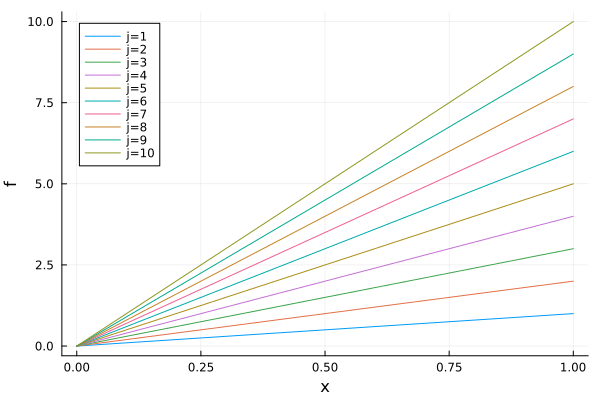

In [33]:
# You may find it useful to have plot! commands in a loop.  Here is an exmple
p1=plot(xlabel="x",ylabel="f")
for j in 1:10
    plot!(x->j*x,label="j="*string(j))
end
display(p1)

<h2 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:red; color:white;" >
## Activity 5
</h2>

As a final step, we want to make a function `distance` which is called with the initial velocity `initialv=(vx,vy)` and the parameters $m,g,\gamma,\delta,dt$, and it tells us how far the projectile travels.

Our strategy is that `distance` will take the input data, and use it to call `projectile_trajectory`.  

We will then take the last two points of the trajectory, and do a linear interpolation to find the value of of $x$ at which $y=0$.  If you want, you can do a higher order interpolation (for example, using our knowledge of the velocities at those points). 

Lets first make a function which is called by those last two values: `xvp=(xp,yp,vxp,vyp)`,for "penultimate" and `xvf= (xp,yp,vxp,vyp)` for "final".  The way I like to derive my linear interpolation formulas, is that I first make a function $x(y)$ which passes through these points.  You should be able to convince yourself that
$$
x(y) = \frac{y-yp}{yf-yp} x_f +  \frac{y-yf}{yp-yf} x_p 
$$
This is obviously a linear function fo $y$ -- and if you plug in the value $y=yp$ or $y=yf$ you get the desired result.  We then just set $y=0$ to find that the projectile hits the ground at
$$
x(0)=\frac{x_f y_p-x_p y_f}{y_p-y_f}
$$
Make a function `interpx0(xvp,xvf)` which implements this formula.  Test to make sure it works.

Now create the function `distance`.  Test it by comparing with a trajectory graph.  A good trick to help check for typos is to use paramters which are "generic" rather than nice.  For example start at `initialv=(3.7,1.2)` with parameters `m=7,gamma=3.2,delta=2,g=9.8`.  Of course, it they don't agree, then go back to nice numbers, which let you systematically track down the issue.

In [36]:
#You may find the following notation useful for accessing the last, and next-to-last elements of a list:
@show lst=[1,2,3,4,5]
@show lst[end]
@show lst[end-1]

lst = [1, 2, 3, 4, 5] = [1, 2, 3, 4, 5]
lst[end] = 5
lst[end - 1] = 4


4

**Use your distance function to create a graph of distance vs $\theta$ for a projectile launched with initial conditions $xv=(0.,0.,\cos(\theta),\sin(\theta))$, and parameters $m=1,g=1,\gamma=0,\delta=2$.  That is, the case of no drag.  You know that the maximum distance should occur at an angle of $\pi/4$.**

Compare with the analytic expression:
\begin{align}
d=\sin(2\theta)
\end{align}

**Repeat, but with strong air drag: $\gamma=4$. What happens to the optimal angle?  Does adding drag make it larger or smaller than $\pi/2$?**